## Tourmaline toolkit in R - 16S Lake Erie Test Data
 Updated: 9/28/2020
 
 Written by: Sean Anderson

This R notebook presents an example of importing and visualizing Tourmaline output files (data and taxonomy files) in R and uses common R packages for visualizing amplicon sequencing data (e.g. phyloseq; McMurdie and Holmes 2013). This test dataset contains samples that were collected from Western Lake Erie in 2018. This example workflow uses a subset of the 16S samples and includes code on how to import QIIME 2 .qza files into R and build plots of alpha and beta diversity and 16S taxonomy bar plots using packages like phyloseq and ggplot2. For this example dataset, samples will be partitioned based on filter size of collected DNA (0.22 vs. 5 um) and sampling region (Western Boundary vs. Open Water).   

Upload R packages needed for this workflow.

In [2]:
library(qiime2R)
library(dplyr)
library(tidyr)
library(phyloseq)
library(tibble)
library(ggplot2)
library(readr)
library(RColorBrewer)

To explore amplicon data in R, the qiime2R package is used, which in this case, uploads QIIME 2 artifact files (.qza files) from the Tourmaline output into R. For this workflow, only the taxonomy and count table are uploaded, though other .qza files produced from Tourmaline (e.g. phylogenetic trees or representative sequences files) can be uploaded using the same approach. Note, the read_qza in qiime2R function requires the user to specify the file path which corresponds to the location of the Tourmaline output for each respective .qza file.

In [6]:
ASVtable_16S <- read_qza(file="/Users/sean.r.anderson/Tourmaline/tourmaline-test/02-output-dada2-pe/00-table-repseqs/table.qza")
ASVtable_16S <- ASVtable_16S$data
ASVtaxa_16S <- read_qza(file="/Users/sean.r.anderson/Tourmaline/tourmaline-test/02-output-dada2-pe/01-alignment-tree-taxonomy/taxonomy.qza")
taxtable_16S <- ASVtaxa_16S$data %>% as_tibble() %>% separate(Taxon, sep=";", c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species"))
taxtable_16S$Consensus <- NULL

# Clean up the taxonomy table a bit: remove unassigned reads at the Kingdom level and relabel taxa to remove unnecessary text (e.g. p__Proteobacteria becomes Proteobacteria)
taxtable_16S <- subset(taxtable_16S, !grepl("Unassigned",taxtable_16S$Kingdom))
taxtable_16S$Kingdom <- gsub("^.{0,3}", "", taxtable_16S$Kingdom)
taxtable_16S$Phylum <- gsub("^.{0,4}", "", taxtable_16S$Phylum)
taxtable_16S$Class <- gsub("^.{0,4}", "", taxtable_16S$Class)
taxtable_16S$Order <- gsub("^.{0,4}", "", taxtable_16S$Order)
taxtable_16S$Family <- gsub("^.{0,4}", "", taxtable_16S$Family)
taxtable_16S$Genus <- gsub("^.{0,4}", "", taxtable_16S$Genus)
taxtable_16S$Species <- gsub("^.{0,4}", "", taxtable_16S$Species)


Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 188 rows [3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 16, 19, 20, 21, 24, 25, 26, 27, 28, 30, ...].”


Upload sample metadata file used in the Tourmaline run. The metadata .tsv file will be in the 00-data subfolder. 

In [8]:
sample_info_tab <- read.table(file="/Users/sean.r.anderson/Tourmaline/tourmaline-test/00-data/metadata.tsv", header=TRUE, row.names=1, sep="\t", na.strings = c("", "NA"))

Merge everything together into a phyloseq object and rename taxa to something easier to understand (e.g. ASV 1, ASV 2, etc.). The phyloseq object will have the taxonomy, count, and metadata files all included, which will make it easy to subset the data (e.g. remove unwanted taxa) or plot data based on factors in the metadata (e.g. in this case by sampling region or filter size of collected DNA). 

In [9]:
physeq_16S <- phyloseq(otu_table(ASVtable_16S, taxa_are_rows= T), tax_table(as.data.frame(taxtable_16S) %>% column_to_rownames("Feature.ID") %>% as.matrix()), sample_data(sample_info_tab))

taxa_names(physeq_16S) <- paste0("ASV", seq(ntaxa(physeq_16S)))

Clean up the 16S test dataset, filtering out any reads that map to Chloroplast or Mitochondria. Other filtering steps can be performed with a larger dataset (e.g. remove controls or samples that have anomalously low read counts).

In [10]:
psnew_16S = subset_taxa(physeq_16S, Order != "Chloroplast" & Family !="Mitochondria")                    

Plot Shannon alpha diversity values for 16S samples, coloring by sampling region, and faceting plots by filter size. Faceting allows the user to more clearly visualize differences in the data between variables of interest. Before plotting, rarefy the samples to the lowest read number in the dataset. Note that Tourmaline produces a rarefied and unrarefied data table, which allows the user flexibility in post-processing and analysis.

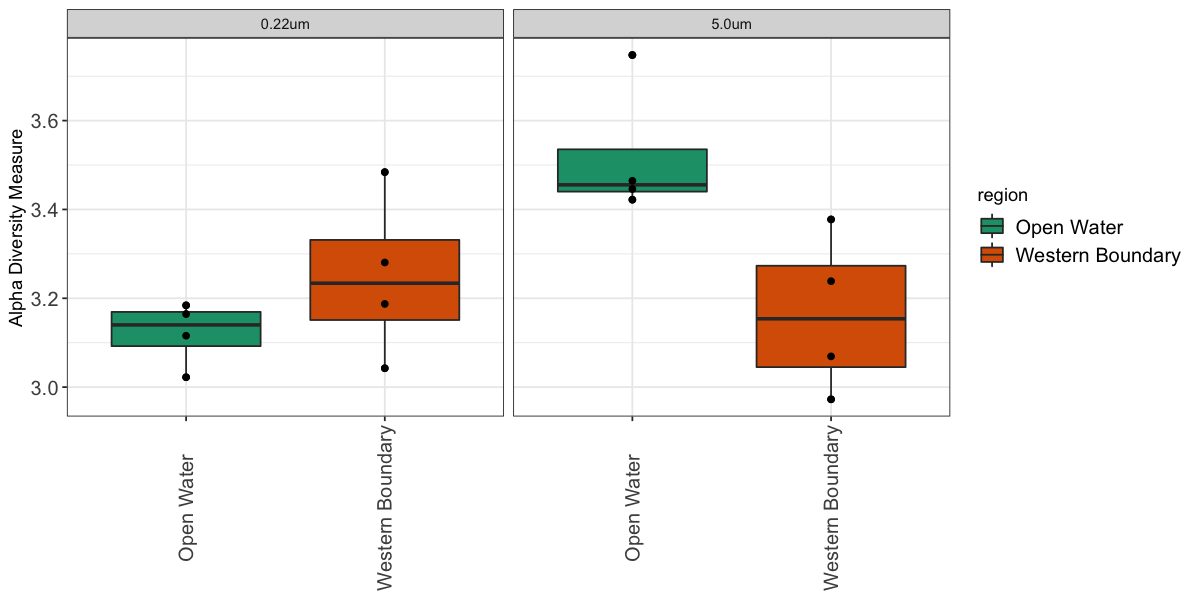

In [15]:
suppressMessages(ps_rarefy_16S <- rarefy_even_depth(psnew_16S, sample.size = min(sample_sums(psnew_16S)), rngseed = 714, replace = TRUE, trimOTUs = TRUE, verbose = TRUE))
p_alpha <- plot_richness(ps_rarefy_16S, x = "region", measures=("Shannon")) # Option to change Shannon and plot the Observed richness, Simpson, or Chao1 metrics instead or in addition to.
p_alpha + geom_boxplot(aes(fill = region)) + geom_point()+ scale_fill_brewer(palette="Dark2") +theme_bw() + facet_grid(~ filter_size, scales = "free_x")+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, size=12)) + theme(axis.text.y = element_text(size=12))+ theme(legend.text = element_text(colour="black", size=12))+theme(axis.title.x = element_blank()) 

options(repr.plot.width=8, repr.plot.height=5)  
#ggsave(filename = "16S_alpha_test.eps", plot = last_plot(), device = "eps", path = NULL, scale = 1, width = 8, height = 5, units = c("in", "cm", "mm"), dpi = 600)                                   

Run an NMDS ordination on the 16S test data and plot the ordination using phyloseq. Beta diversity analyses in phyloseq wrap in the vegan package (Oksanen 2019). For this set, we will exclude global singletons (ASVs only found once in the set) and transform the data to relative abundance. Samples are colored by region using the same color palette and have shapes based on 0.22 vs. 5 um filter size. 

Run 0 stress 0.1065152 
Run 1 stress 0.1065152 
... Procrustes: rmse 8.620958e-06  max resid 2.473362e-05 
... Similar to previous best
Run 2 stress 0.1582645 
Run 3 stress 0.1071249 
Run 4 stress 0.1071249 
Run 5 stress 0.1571797 
Run 6 stress 0.1065152 
... New best solution
... Procrustes: rmse 5.679972e-06  max resid 1.703611e-05 
... Similar to previous best
Run 7 stress 0.1519423 
Run 8 stress 0.1153811 
Run 9 stress 0.1153811 
Run 10 stress 0.1065152 
... Procrustes: rmse 1.178575e-05  max resid 2.491836e-05 
... Similar to previous best
Run 11 stress 0.1065152 
... Procrustes: rmse 1.840518e-05  max resid 5.234869e-05 
... Similar to previous best
Run 12 stress 0.1153811 
Run 13 stress 0.1071248 
Run 14 stress 0.1065152 
... Procrustes: rmse 4.575748e-05  max resid 0.0001332152 
... Similar to previous best
Run 15 stress 0.1065152 
... New best solution
... Procrustes: rmse 1.91851e-06  max resid 4.000994e-06 
... Similar to previous best
Run 16 stress 0.1065152 
... New best s

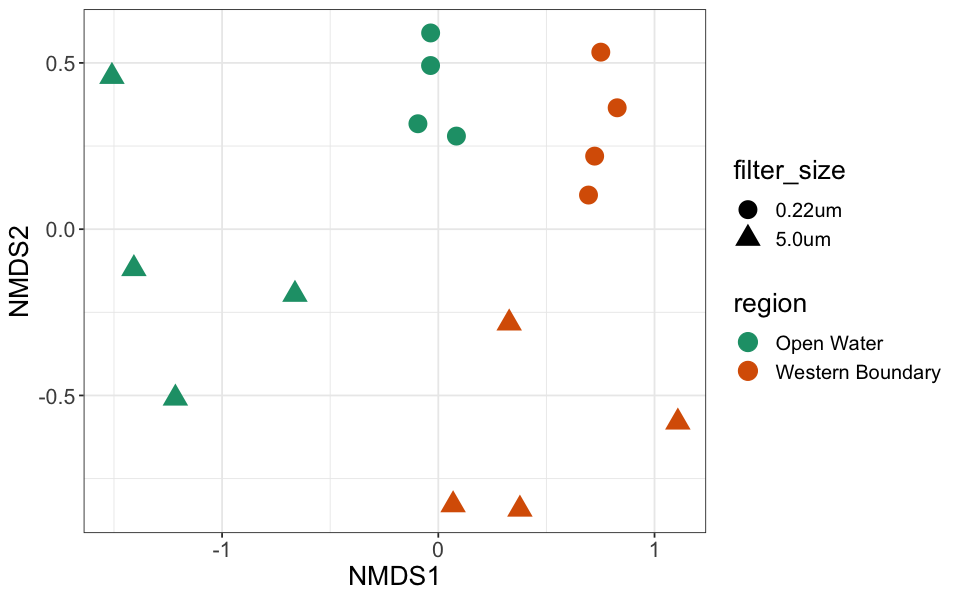

In [22]:

ps_rarefy_16S = filter_taxa(ps_rarefy_16S, function (x) {sum(x) > 1}, prune=TRUE)
ps_16S_rel  <- transform_sample_counts(ps_rarefy_16S,function(x) x/sum(x))
ps_16S_ord  <- ordinate(ps_16S_rel, "NMDS", "bray")
p_beta = plot_ordination(ps_16S_rel, ps_16S_ord, color="region", shape = "filter_size")
p_beta + theme_bw() + theme(text = element_text(size = 16)) + geom_point(aes(color=region, shape = filter_size),size = 5) + scale_color_brewer(palette="Dark2") + theme(legend.text = element_text(colour="black", size=12))  

options(repr.plot.width=8, repr.plot.height=5) 
#ggsave(filename = "16S_nmds_test.eps", plot = last_plot(), device = "eps", path = NULL, scale = 1, width = 8, height = 5, units = c("in", "cm", "mm"), dpi = 600)                                   

Plot stacked taxonomy bar plots of the top 16S taxa groups at the Class level (similar approach used for any other taxonomic level) for 0.22 um and 5 um samples. Taxa that are < 5% in any given sample are grouped into an "other" category. Samples are faceted based on the sampling region in Lake Erie. Bar plots can be heavily customized using ggplot2. Additional steps used here are annotated along with the code to provide context for 16S bar plots.  

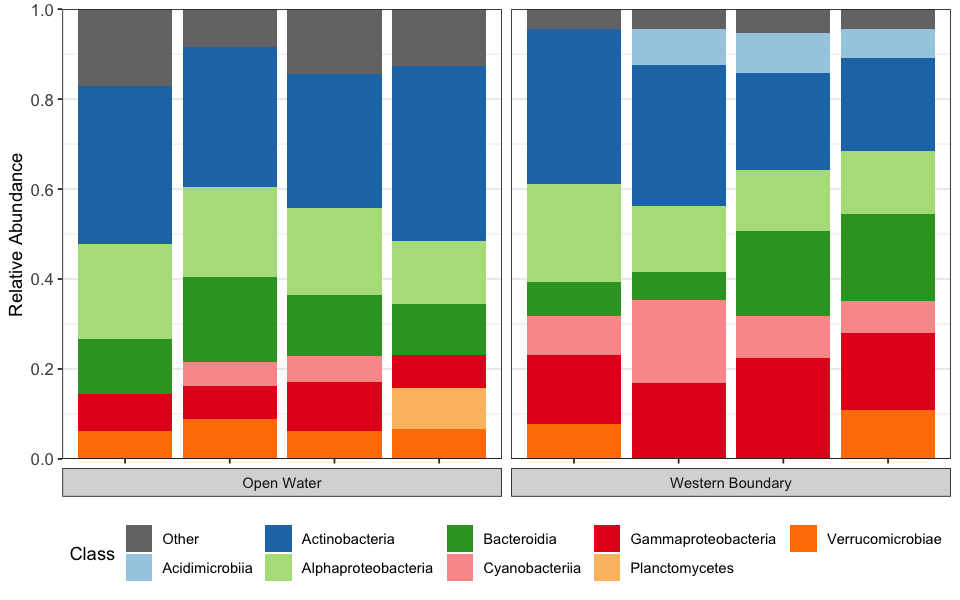

In [23]:
# Subset to the 0.22 um samples
ps22_rarefy_16S <- subset_samples(ps_rarefy_16S, filter_size == "0.22um")

# Format the data
x1 <- tax_glom(ps22_rarefy_16S, taxrank = 'Class', NArm=FALSE) # Agglomerate to Class level
x2 <- transform_sample_counts(x1, function(x) x/sum(x)) # Transform to relative abundance
x3 <- psmelt(x2) # Melt the data to long format
x3$Class<- as.character(x3$Class) # Convert to character
x3$Class[x3$Abundance < 0.05]= "Other" # Establish "other" category

p_taxa <- ggplot(data=x3, aes(x= sample_station, y=Abundance, fill=Class))

# Control the order of taxa that show up in the bar plots and create a color palette based on # of colors needed (10 in this case).
p_taxa$data$Class <- factor(p_taxa$data$Class, levels = c("Other", "Acidimicrobiia", "Actinobacteria", "Alphaproteobacteria", "Bacteroidia", "Cyanobacteriia", "Gammaproteobacteria", "Planctomycetes","Verrucomicrobiae"))
mycolors = c("#757575", brewer.pal(name="Paired", n = 12))

# New facet label names for sampling regions
regions.labs <- c("Open Water", "Western Boundary")
names(regions.labs) <- c("Open Water", "Western Boundary")

# Plot bar plots
p_taxa + geom_bar(stat="identity", position = "stack")+scale_y_continuous(expand = c(0, 0), breaks=seq(0,1,0.2), limits=c(0, 1)) + geom_hline(yintercept=0) + theme_bw()+ scale_fill_manual(values=mycolors)+ theme(axis.text.x=element_text(angle=90,vjust=0.5, size=10)) + theme(axis.text.y=element_text(size=10))+ theme(legend.position="bottom") +
theme(axis.text.x = element_blank()) + guides(fill=guide_legend(nrow=2)) + theme(axis.title.x=element_blank())+ labs(y = "Relative Abundance") + facet_grid(~region, labeller = labeller(region = regions.labs), scales = "free_x", space = "free", switch = "x")+ theme(strip.placement = "outside")

                              
options(repr.plot.width=8, repr.plot.height=5)   
#ggsave(filename = "16S_taxa_plot_test.eps", plot = last_plot(), device = "eps", path = NULL, scale = 1, width = 10, height = 5, units = c("in", "cm", "mm"), dpi = 600)                                   

Reapeat the same taxa bar plots, this time with the 5 um filter size samples!

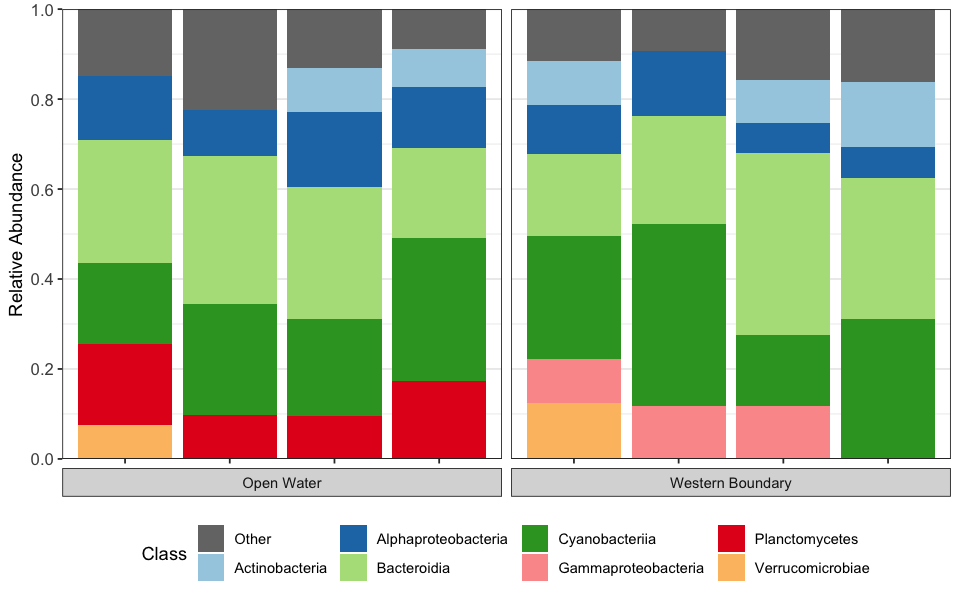

In [24]:
# Subset to the 5.0 um samples
ps5_rarefy_16S <- subset_samples(ps_rarefy_16S, filter_size == "5.0um")

# Format the data
x1 <- tax_glom(ps5_rarefy_16S, taxrank = 'Class', NArm=FALSE) # Agglomerate to Class level
x2 <- transform_sample_counts(x1, function(x) x/sum(x)) # Transform to relative abundance
x3 <- psmelt(x2) # Melt the data to long format
x3$Class<- as.character(x3$Class) # Convert to character
x3$Class[x3$Abundance < 0.05]= "Other" # Establish "other" category

p_taxa <- ggplot(data=x3, aes(x= sample_station, y=Abundance, fill=Class))

# Control the order of taxa that show up in the bar plots and create a color palette based on # of colors needed (10 in this case).
p_taxa$data$Class <- factor(p_taxa$data$Class, levels = c("Other", "Acidimicrobiia", "Actinobacteria", "Alphaproteobacteria", "Bacteroidia", "Cyanobacteriia", "Gammaproteobacteria", "Planctomycetes","Verrucomicrobiae"))
mycolors = c("#757575", brewer.pal(name="Paired", n = 12))

# New facet label names for sampling regions
regions.labs <- c("Open Water", "Western Boundary")
names(regions.labs) <- c("Open Water", "Western Boundary")

# Plot bar plots
p_taxa + geom_bar(stat="identity", position = "stack")+scale_y_continuous(expand = c(0, 0), breaks=seq(0,1,0.2), limits=c(0, 1)) + geom_hline(yintercept=0) + theme_bw()+ scale_fill_manual(values=mycolors)+ theme(axis.text.x=element_text(angle=90,vjust=0.5, size=10)) + theme(axis.text.y=element_text(size=10))+ theme(legend.position="bottom") +
theme(axis.text.x = element_blank()) + guides(fill=guide_legend(nrow=2)) + theme(axis.title.x=element_blank())+ labs(y = "Relative Abundance") + facet_grid(~region, labeller = labeller(region = regions.labs), scales = "free_x", space = "free", switch = "x")+ theme(strip.placement = "outside")

                              
options(repr.plot.width=8, repr.plot.height=5)   
#ggsave(filename = "16S_taxa_plot_test.eps", plot = last_plot(), device = "eps", path = NULL, scale = 1, width = 10, height = 5, units = c("in", "cm", "mm"), dpi = 600)                                   